In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, precision_recall_curve, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator

**TAKEAWAYS**

- Classification models are built on a dataset with product and user information, with the outcome as target. The models return '1' if they predict a certain user will buy the selected product
- Dataset filtered to only show orders with more than 4 products
- The target class is very sparse (only 1.5% positives compared to negatives), which makes the classification harder
- Different algorithms are tried, displaying roc-auc curve and precision-recall curve as metrics. Some hyperparameters are tweaked to compare the algorithms and select the best for the MVP
- Regularization does not have a big impact because the models aren't too complex for the size of the dataset
- The models' results are not very different from  each other. We select logistic regression

In [2]:
df = pd.read_csv('/home/alvaro/groceries/boxbuilder.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [3]:
df.created_at = pd.to_datetime(df.created_at)
df.order_date = pd.to_datetime(df.order_date,format='%Y-%m-%d %H:%M:%S')

In [4]:
df.order_id.nunique()

3446

In [5]:
# filter to only keep orders with more than 5 bought products
ids = df[df.outcome == 1].groupby('order_id').variant_id.count() > 4
ids[ids == True].index

Index([2807985930372, 2808027644036, 2808099078276, 2808393957508,
       2808434524292, 2808548917380, 2808549900420, 2808728715396,
       2808769085572, 2808786714756,
       ...
       3643189461124, 3643199160452, 3643226718340, 3643229274244,
       3643240185988, 3643241300100, 3643254800516, 3643274788996,
       3643283734660, 3643294515332],
      dtype='int64', name='order_id', length=2603)

2603 of the 3446 orders of the dataset have at least 5 bought products in them.

In [6]:
df2 = df[df.order_id.isin(ids[ids == True].index)]
df2.shape

(2163953, 27)

In [7]:
df2.outcome.value_counts()[1]/df2.outcome.value_counts()[0]*100

1.4690353292469747

Target is very unbalanced, with positive class rows being only 1.5% relative to the negative class. We will have to take this into account when training the model

In [8]:
cols_categoricas = df2[['vendor','product_type']]
cols_categoricas.nunique()

vendor          264
product_type     62
dtype: int64

In [ ]:
# Frequency encoding
for col in cols_categoricas.columns: 
    frequency_map = df2[col].value_counts(normalize=True).to_dict()
    df2.loc[:,f'{col}_freq_encoded'] = df2[col].map(frequency_map)
df3 = df2.drop(cols_categoricas.columns.to_list(), axis=1)

In [10]:
# prevent info leakage by separating train, validation and test sets by time
df3 = df3.sort_values(by='order_date')
X = df3.drop(['outcome'], axis=1)  
y = df3.outcome

# train 0,6 and val+test 0,4
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, shuffle=False)
# validation 0,2, test 0,2
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=False)

In [11]:
# drop unncecessary columns
drop = ['variant_id',"order_id","user_id","created_at","order_date"]
X = df3.drop(['outcome'], axis=1)  
X_train = X_train.drop(drop, axis=1)  
X_val = X_val.drop(drop, axis=1)
X_test = X_test.drop(drop, axis=1)

# scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_val = scaler.transform(X_val) 
X_test = scaler.transform(X_test) 

The train, validation and test sets are assigned the arbitrary proportions of 0.6, 0.2 and 0.2 respectively. The data is also scaled as it works better for these models. 

In [12]:
def plot_curves(model: BaseEstimator,param:str, X: pd.DataFrame, y: pd.Series):
        
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X)

    fpr, tpr, thresholds = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)
    prec, rec, thresholds = precision_recall_curve(y, y_scores)
    pr_auc = auc(rec, prec)

    fig, axs = plt.subplots(1,2, figsize=(12, 5))
    axs[0].plot(fpr, tpr, label= f'{param}, AUC = %.2f' % roc_auc)
    axs[1].plot(rec, prec, label= f'{param}, AUC = %.2f' % pr_auc)

    axs[0].set_title('ROC curve')
    axs[0].set_xlabel('False positive rate')
    axs[0].set_ylabel('True positive rate')
    axs[0].legend(loc="upper right")

    axs[1].set_title('Precision-recall curve')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend(loc="upper right")
    
    plt.show()

Logistic regression

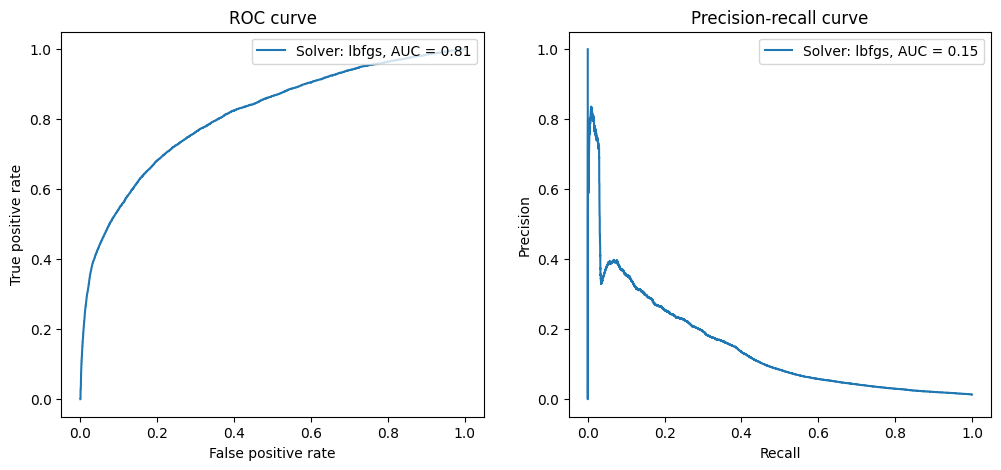

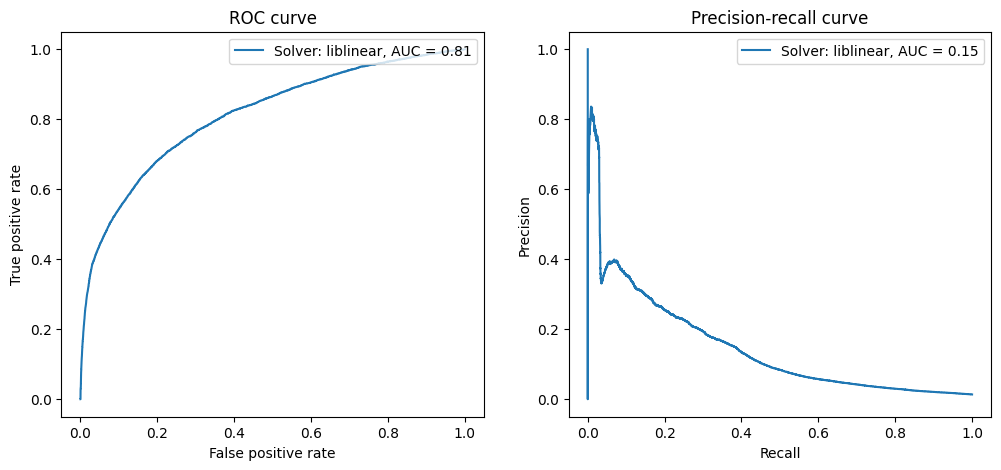

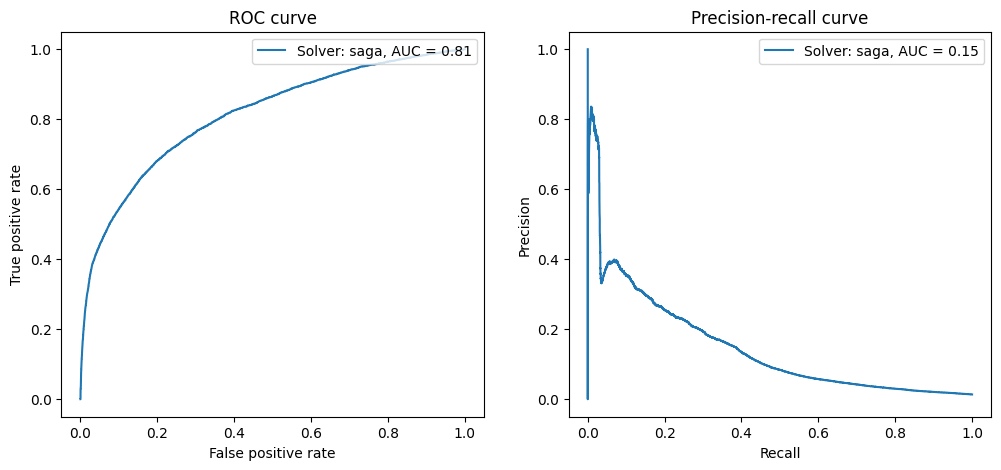

In [13]:
solvers = ['lbfgs','liblinear','saga']

for solver in solvers:

    model = LogisticRegression(solver=solver)
    model.fit(X_train, y_train)
    param = f'Solver: {solver}'
    plot_curves(model, param, X_val, y_val)

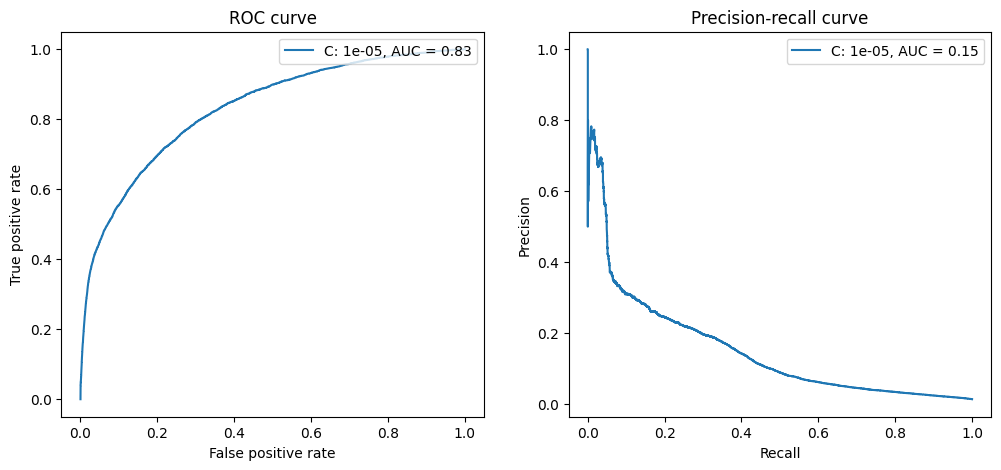

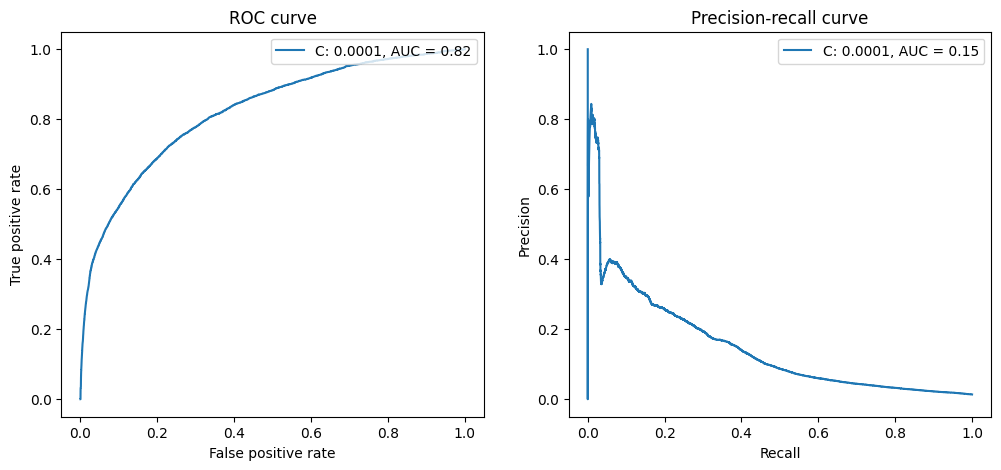

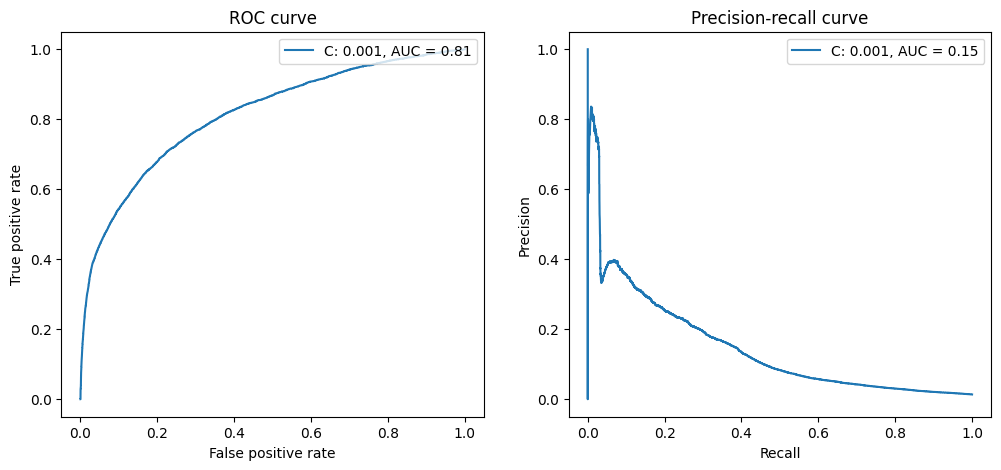

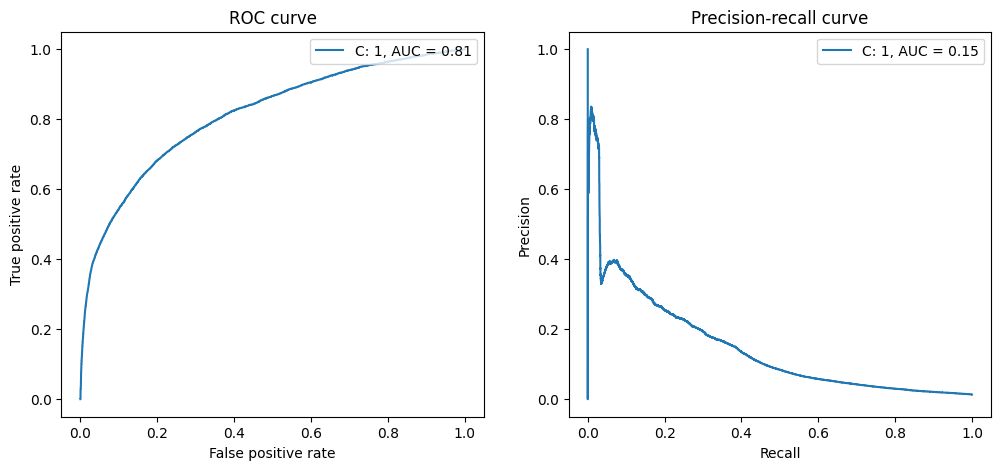

In [ ]:
# adjust regularization parameter C
Cs = [0.00001, 0.0001, 0.001,1]

for C in Cs:
    model = LogisticRegression(solver='lbfgs',C=C)
    model.fit(X_train, y_train)
    param = f'C: {C}'
    plot_curves(model, param, X_val, y_val)

Precision can be improved at cost of true positive detection by implementing a stronger regularization. In this case, regularization and different solvers do not affect the result that much because the model complexity is low for the number of samples.

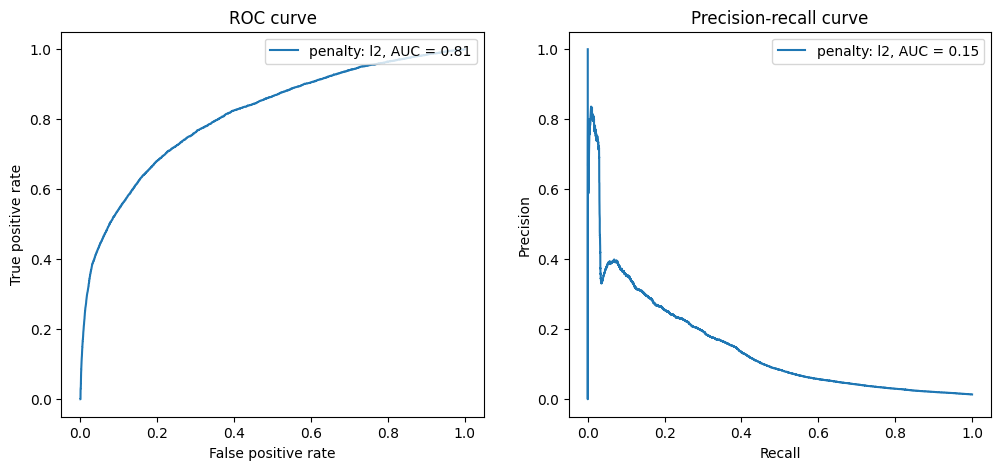

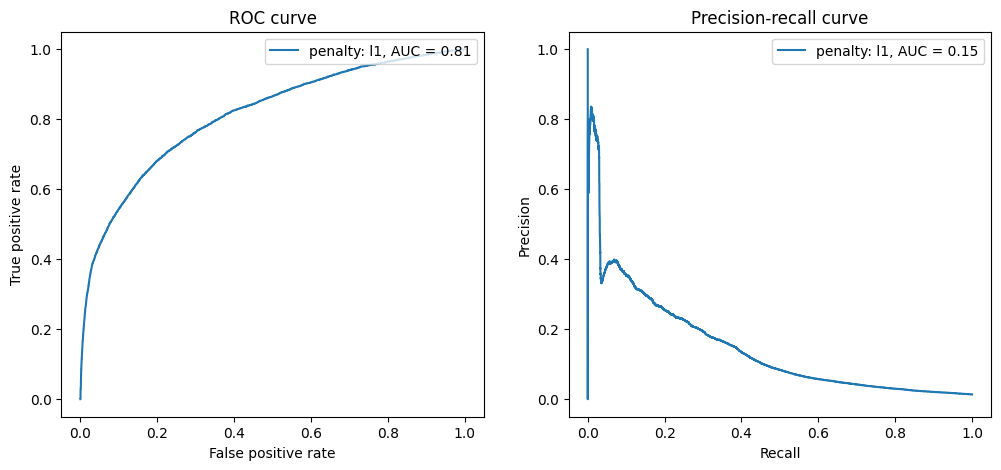

In [15]:
# compare penalties (ridge and lasso)
penalties = ['l2','l1']

for penalty in penalties:

    model = LogisticRegression(penalty=penalty,solver='liblinear')
    model.fit(X_train, y_train)
    param = f'penalty: {penalty}'
    plot_curves(model, param, X_val, y_val)

No remarkable difference in results between the two regularizations

Perceptron

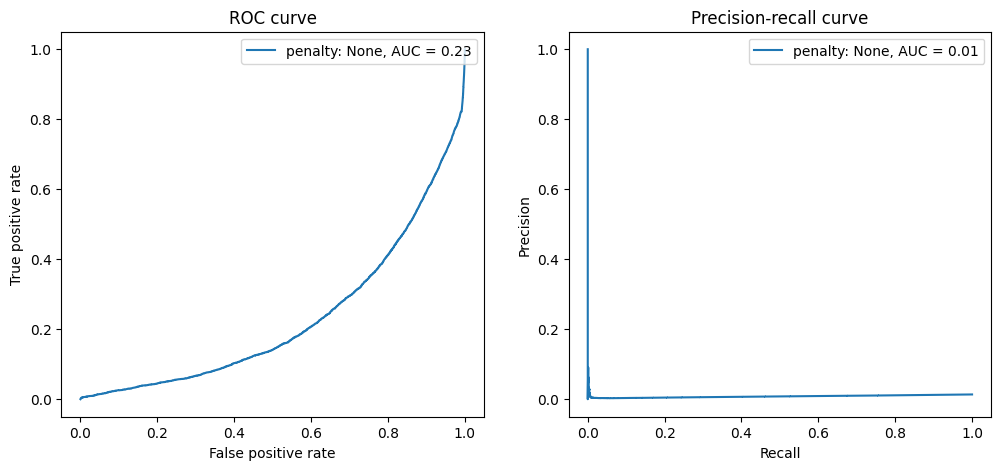

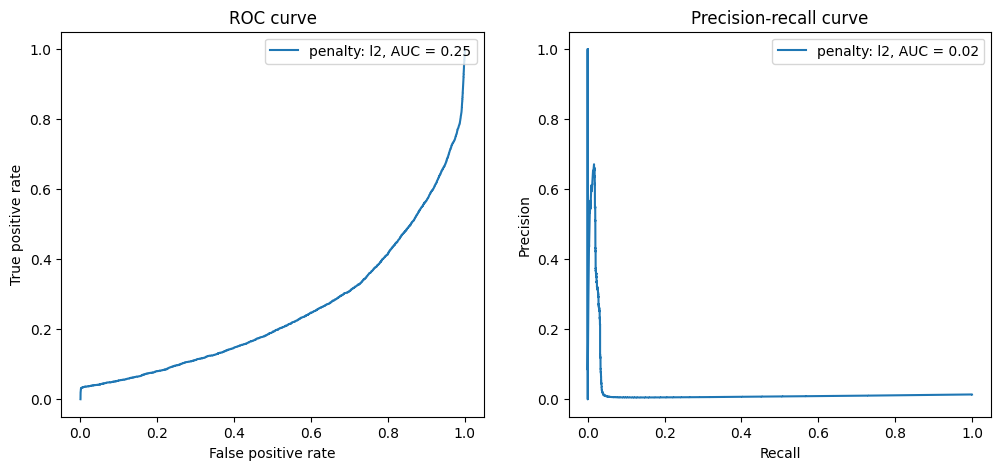

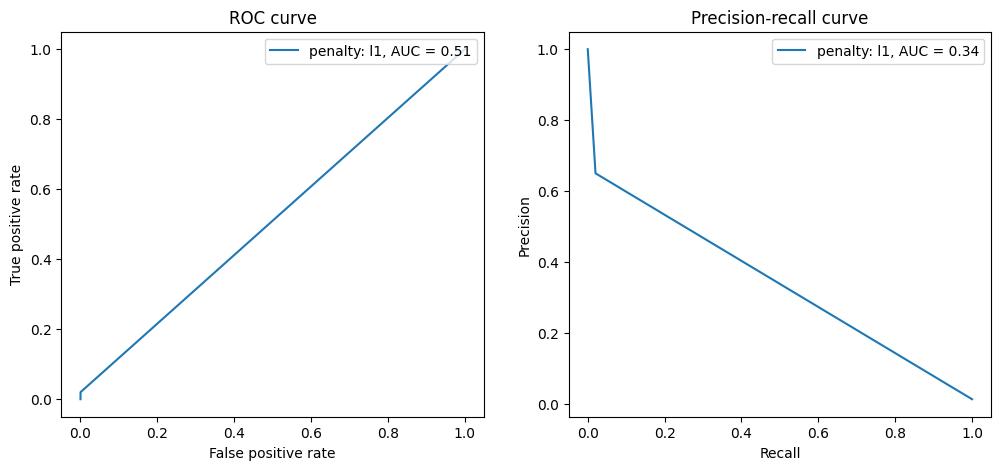

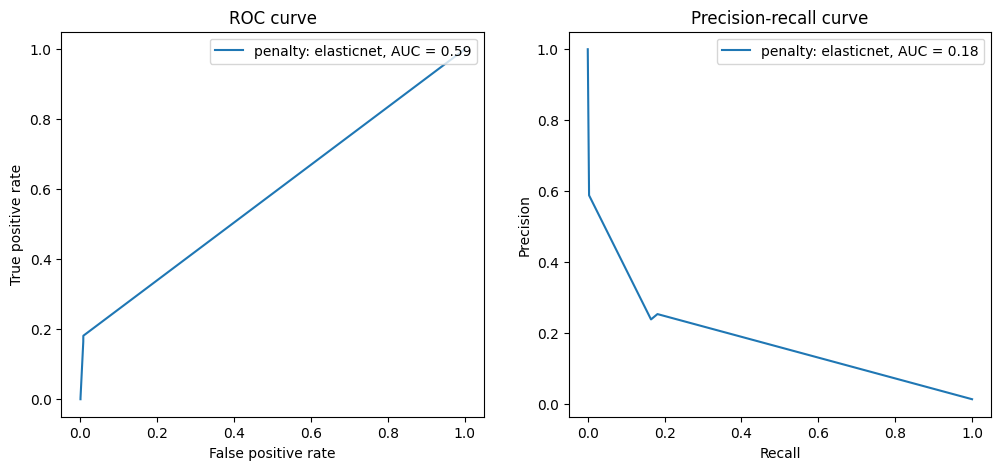

In [16]:
penalties = [None,'l2','l1','elasticnet']

for penalty in penalties:

    model = Perceptron(penalty=penalty)
    model.fit(X_train, y_train)
    param = f'penalty: {penalty}'
    plot_curves(model, param, X_val, y_val)

Precision-recall AUC seems to be better but we can't trust this plot since it has very few points.

LinearSVC

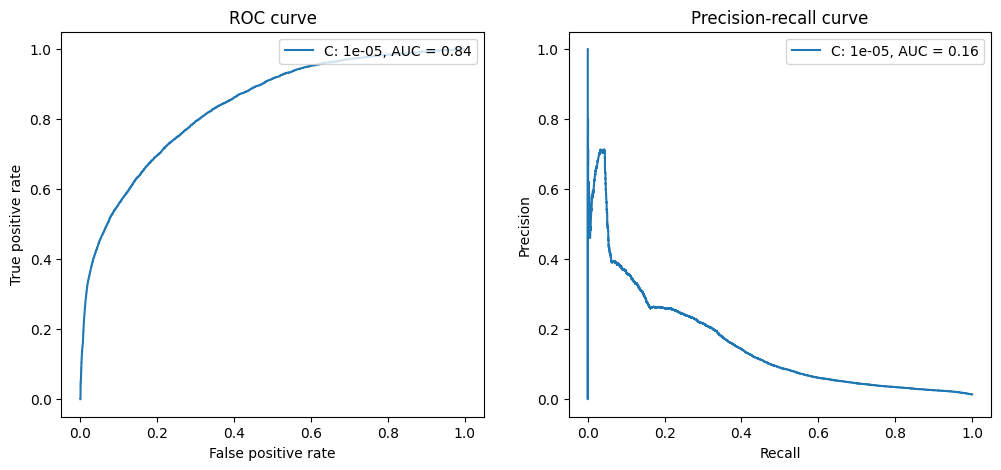

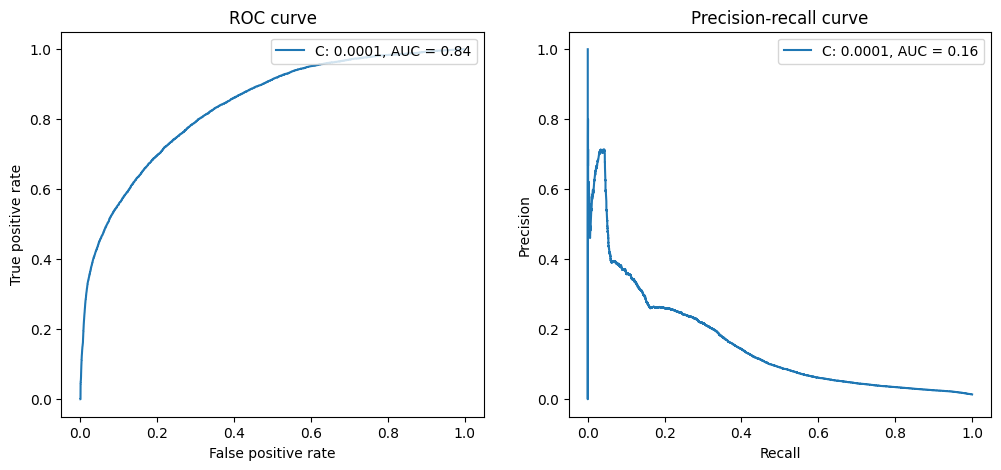

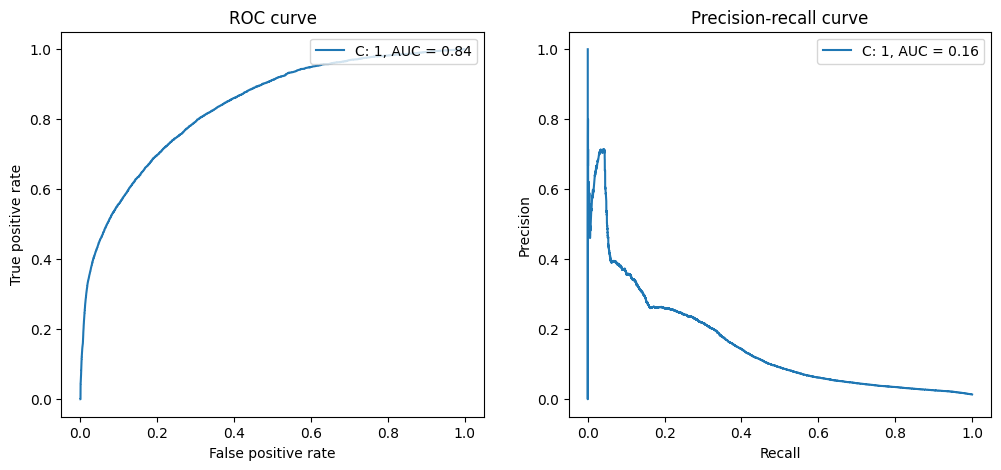

: 

In [17]:
# adjust regularization parameter C
Cs = [0.00001, 0.0001, 1]

for C in Cs:

    model = LinearSVC(C=C)
    model.fit(X_train, y_train)
    param = f'C: {C}'
    plot_curves(model, param, X_val, y_val)

The AUC is slightly better than in logistic regression, however, we could choose either model for the MVP depending on the specific recall or precision required. 

In our case, precision may be prioritized over recall because the downside of getting too much false positives is big, as it results in the users receiving many push notifications of products they are not interested in which makes them uninstall the app. 